# Variáveis Exógenas

Como séries temporais possuem uma ordem temporal, a sua própria história tem poder preditivo muito forte. No entanto, em alguns casos, apenas a história não é suficiente para fazer previsões precisas.

Por exemplo, em vendas de varejo, fatores como promoções, feriados e eventos sazonais podem impactar significativamente as vendas.

Agora, vamos ver como usar variáveis exógenas em modelos de séries temporais com sktime, as famosas "features".

A interface é sempre a mesma, vamos ver que a diferença é o uso do parâmetro `X` nos métodos `fit` e `predict`.

Usaremos os mesmos dados de varejo sintético dos exemplos anteriores. Agora, teremos também `X_train` e `X_test`, que são as variáveis exógenas.


In [1]:
from tsbook.datasets.retail import SyntheticRetail
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster

dataset = SyntheticRetail("univariate", macro_trend=True)
y_train, X_train, y_test, X_test = dataset.load(
    "y_train", "X_train", "y_test", "X_test"
)

X_train.head()

,promo,macro_trend
date,,
2020-01-01,0.0,1.304000
2020-01-02,0.0,1.327826
2020-01-03,0.0,1.350638
2020-01-04,0.0,1.361667
2020-01-05,0.0,1.361633


<Axes: xlabel='date'>

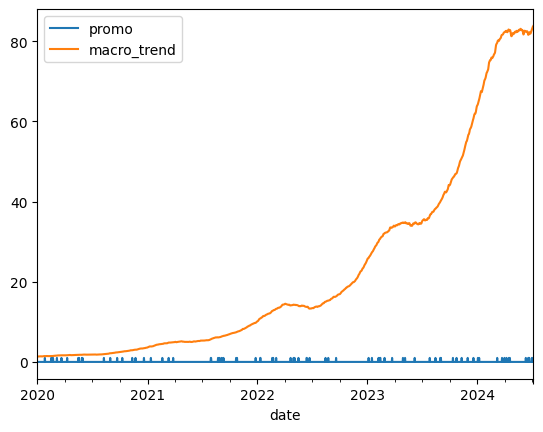

In [2]:
import matplotlib.pyplot as plt

X_train.plot.line()

<Axes: xlabel='date'>

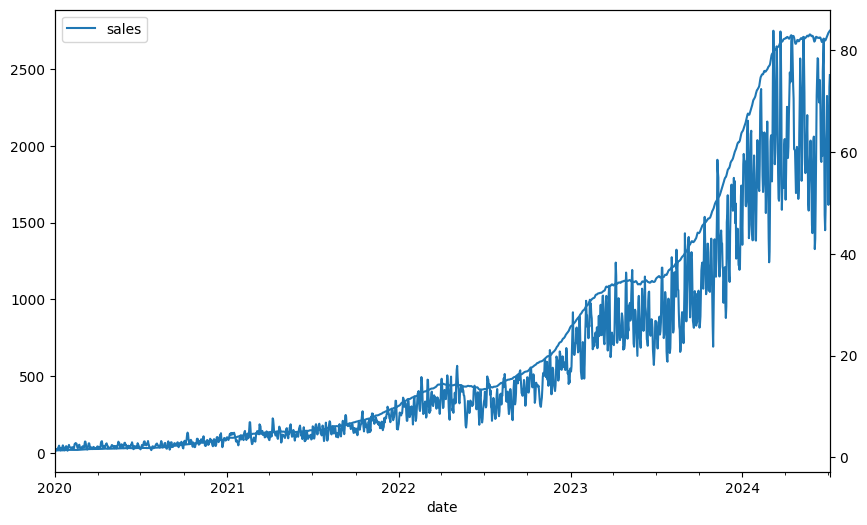

In [3]:
fig, ax = plt.subplots( figsize=(10, 6))

y_train.plot(ax=ax, label="y")
X_train["macro_trend"].plot(ax=ax.twinx(), label="macro_trend")


Nem todos modelos suportam variáveis exógenas. Para ver uma lista de possibilidades, podemos usar a função `all_estimators` do sktime.

In [4]:
from sktime.registry import all_estimators

all_estimators(
    "forecaster", filter_tags={"capability:exogenous": True}, as_dataframe=True
)

,name,object
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
1,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
2,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
3,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
4,AutoREG,<class 'sktime.forecasting.auto_reg.AutoREG'>
...,...,...
77,UpdateEvery,<class 'sktime.forecasting.stream._update.Upda...
78,UpdateRefitsEvery,<class 'sktime.forecasting.stream._update.Upda...
79,VARMAX,<class 'sktime.forecasting.varmax.VARMAX'>
80,VECM,<class 'sktime.forecasting.vecm.VECM'>


## Tipos de Variáveis Exógenas

Antes de prosseguirmos, vamos separar as variáveis exógenas em dois tipos:

* **Variáveis exógenas com valores futuros conhecidos**: São variáveis cujos valores futuros já são conhecidos no momento da previsão. Variáveis indicadoras (dummies) para feriados ou eventos especiais, bem como recursos de sazonalidade, são exemplos comuns desse tipo de variável.

* **Variáveis exógenas com valores futuros desconhecidos**: São variáveis cujos valores futuros não são conhecidos para o horizonte de previsão. Por exemplo, se quisermos incluir indicadores econômicos que ainda não foram divulgados, devemos tratá-los como variáveis exógenas de valor futuro desconhecido.
  
Nesse último cenário, para realizar a previsão, existem três opções:
	1.	Prever os valores futuros das variáveis exógenas usando um modelo separado (ou o mesmo modelo, se ele permitir) e usar essas previsões como entrada para o modelo principal de previsão.
	2.	Usar um valor de preenchimento (por exemplo, o último valor conhecido) para as variáveis exógenas de valor futuro desconhecido durante a previsão.
	3.	Usar valores defasados (lags) das variáveis exógenas como características (features), o que pode ser útil se o modelo conseguir aprender com os valores passados dessas variáveis.

## Usando variáveis exógenas com sktime

Vamos usar `AutoREG` como modelo base para nosso exemplo de vairáveis exógenas. Primeiramente, vamos supor que conhecemos a variável `macro_trend` no futuro

In [5]:
from sktime.forecasting.auto_reg import AutoREG

model = AutoREG(lags=30)
model.fit(y_train, X=X_train)
y_pred = model.predict(fh=y_test.index, X=X_test)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

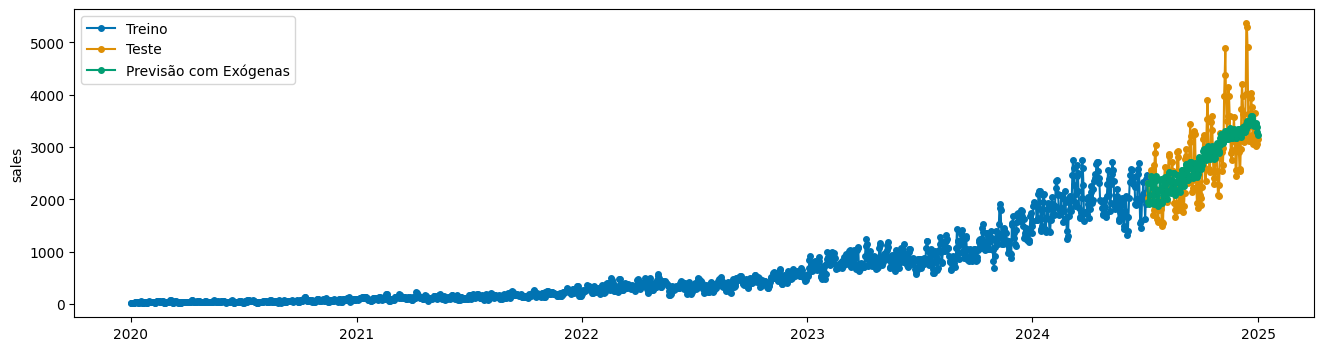

In [6]:
plot_series(y_train, y_test, y_pred, labels=["Treino", "Teste", "Previsão com Exógenas"])

Fácil, no caso que conhecemos a variável exógena no futuro, basta passar `X` em `fit` e `predict`.

Antes de avançar, é importante revisar que os transformadores com `fit` e `transform` também podem ser aplicados a variávei exógenas! Inclusive, podemos fazer pipelines compostos de várias etapas de preprocessamento de exógenas. Isso será importante para os próximos exemplos.

## Variável observada, mas desconhecida no futuro

Vamos eliminar a variável `macro_trend` do conjunto de teste, para simular o cenário onde não conhecemos o valor futuro dessa variável.

In [7]:
import numpy as np

X_test_missing = X_test.copy()
X_test_missing["macro_trend"] = np.nan

### Solução 1: Prever a variável exógena

Agora, vamos supor que não sabemos o valor futuro de `macro_trend`. Nesse caso, podemos criar um modelo separado para prever `macro_trend` e usar essa previsão como entrada para o modelo principal.

Sktime possui uma funcionalidade pronta para isso: um forecaster chamado `ForecastX`. Ele é composto de dois modelos, um para a variável exógena, e outro para o alvo principal.

Aqui, o forecaster necessita que o horizonte de previsão (`fh`) seja passado já na etapa de `fit`.

In [8]:
from sktime.forecasting.compose import ForecastX

model = ForecastX(
    forecaster_y=AutoREG(lags=30),
    forecaster_X=AutoREG(lags=30),
)

fh = [i for i in range(1, len(y_test) + 1)]
model.fit(y_train, X=X_train, fh=fh)

y_pred_case1 = model.predict(X=X_test_missing)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

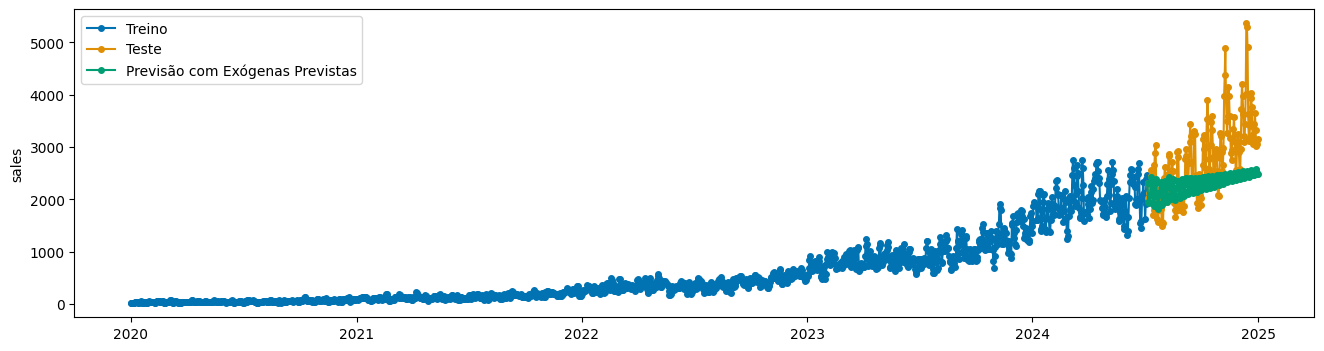

In [9]:
plot_series(y_train, y_test, y_pred_case1, labels=["Treino", "Teste", "Previsão com Exógenas Previstas"])

### Solução 2: Usar valor de preenchimento (imputação)

Para essa solução, vamos usar transformadores para preencher os valores faltantes na variável exógena. Aqui, usaremos o `Imputer` do sktime, que suporta variáveis exógenas.

In [10]:
from sktime.transformations.series.impute import Imputer
imputer = Imputer(method="mean")
imputer.fit(X_train)

# Agora imputamos
X_test_imputed = imputer.transform(X_test_missing)
X_test_imputed.tail()

,promo,macro_trend
date,,
2024-12-28,0.0,22.805784
2024-12-29,0.0,22.805784
2024-12-30,0.0,22.805784
2024-12-31,1.0,22.805784
2025-01-01,0.0,22.805784


Para usar preprocessamento de exógenas + forecasting, podemos usar a composição `ForecastingPipeline`.

In [11]:
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.difference import Differencer


model = ForecastingPipeline(
    steps=[("imputer", Imputer(method="mean")), ("forecaster", AutoREG(lags=30))]
)
model.fit(y_train, X=X_train)

ForecastingPipeline(steps=[('imputer', Imputer(method='mean')),
                           ('forecaster', AutoREG(lags=30))])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

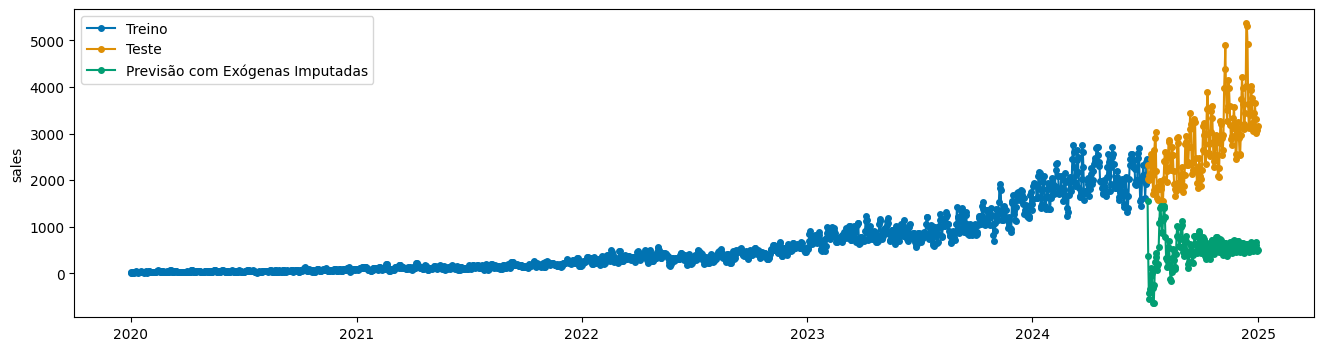

In [12]:
y_pred_case2 = model.predict(fh=y_test.index, X=X_test_missing)
plot_series(y_train, y_test, y_pred_case2, labels=["Treino", "Teste", "Previsão com Exógenas Imputadas"])

Nossa previsão não ficou boa. Claro! A variável exógena possui uma tendência - que naturalmente faz com que a imputação do ultimo valor ou a média não funcione bem. A solução ótima varia de caso para caso.


::: {.callout-tip}

**Dica**: Podemos também usar o operador `**` como atalho para criar pipelines de variáveis exógenas.

```python
model = Imputer(method="mean") ** AutoREG(lags=30)
````

Note a diferença do que aprendemos para criar pipelines com transformações na variável target, que usam `*` como operador. Claramente, podemos fazer composições mais complexas, como:

```python
model = Imputer(method="mean") ** (Differencer() * AutoREG())
```

:::

### Solução 3: Usar valores defasados (lags) da variável exógena

Outra opção é criar versões defasadas das variáveis exógenas e usá-las como features.

Para isso, podemos usar o transformador Lag do sktime.
Ao utilizar defasagens (lags), surgem dois desafios principais:

1.	O aparecimento de valores NaN, que muitos modelos de previsão não conseguem tratar.

2.	O número de variáveis exógenas pode aumentar significativamente, o que pode levar a overfitting ou, no caso do nosso conjunto de dados, a um número de features maior que o número de amostras — o que pode gerar erros no processo de ajuste (fitting).

Para lidar com isso, no exemplo abaixo utilizamos um TransformerPipeline que realiza as seguintes etapas:

* Seleção de variáveis: executa uma seleção das variáveis exógenas, mantendo apenas as mais relevantes.
* Defasagem: aplica o transformador Lag para criar versões defasadas das variáveis exógenas.
* Imputação: usa o transformador Imputer para preencher os valores NaN criados pelo processo de defasagem. Neste caso, é usado o método backfill (preenchimento a partir de valores posteriores).

In [13]:
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.feature_selection import FeatureSelection
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.lag import Lag
from sktime.transformations.series.subset import IndexSubset


transformer_pipeline = TransformerPipeline(
    steps=[
        ("lag", Lag(lags=list(range(1, 180 + 1)))),  # Cria lags 3 e 4
        ("subset", IndexSubset()),  # Seleciona apenas macro_trend
        ("impute", Imputer(method="backfill", value=0)),  # Imputa valores NaN
        ("feature_selection", FeatureSelection()),  # Seleciona features
    ]
)

In [14]:
transformer_pipeline.fit(X=X_train, y=y_train)
X_test_transformed = transformer_pipeline.transform(X=X_test_missing)

X_test_transformed.head()

,lag_98__macro_trend,lag_34__macro_trend,lag_17__macro_trend,lag_104__macro_trend,lag_67__macro_trend,lag_36__macro_trend,lag_35__macro_trend,lag_9__macro_trend,lag_22__macro_trend,lag_6__macro_trend,...,lag_119__promo,lag_129__macro_trend,lag_34__promo,lag_33__promo,lag_47__macro_trend,lag_159__macro_trend,lag_114__promo,lag_91__promo,lag_136__macro_trend,lag_71__macro_trend
date,,,,,,,,,,,,,,,,,,,,,
2024-07-06,82.233778,81.711556,81.654222,81.633778,81.764000,82.488444,82.042667,82.259556,82.534667,82.909333,...,0.0,77.054667,0.0,0.0,82.734222,71.103556,0.0,0.0,76.021333,81.838222
2024-07-07,82.288444,81.823556,81.886667,81.660444,81.880444,82.042667,81.711556,82.540444,82.463556,83.153778,...,0.0,77.324889,0.0,0.0,82.791556,71.535556,0.0,1.0,76.131111,82.044889
2024-07-08,82.319556,82.084889,82.160889,81.724444,82.063111,81.711556,81.823556,82.741333,82.210222,83.440444,...,0.0,77.896000,0.0,0.0,82.934667,71.861333,0.0,0.0,76.268889,82.003111
2024-07-09,82.393778,82.555556,82.290222,81.875556,82.175556,81.823556,82.084889,82.909333,81.881778,83.594667,...,0.0,78.460444,0.0,0.0,83.110222,72.159111,0.0,0.0,76.441333,81.840889
2024-07-10,82.383556,82.657333,82.144889,82.086222,82.288000,82.084889,82.555556,83.153778,81.639111,83.721778,...,0.0,79.001778,0.0,0.0,83.123111,72.249778,0.0,0.0,76.692889,81.764000


In [15]:
model = ForecastingPipeline(
    steps=[
        ("preprocessing", transformer_pipeline),
        ("forecaster", AutoREG(lags=30)),
    ]
).fit(X=X_train, y=y_train)


model

ForecastingPipeline(steps=[('preprocessing',
                            TransformerPipeline(steps=[('lag',
                                                        Lag(lags=[1, 2, 3, 4, 5,
                                                                  6, 7, 8, 9,
                                                                  10, 11, 12,
                                                                  13, 14, 15,
                                                                  16, 17, 18,
                                                                  19, 20, 21,
                                                                  22, 23, 24,
                                                                  25, 26, 27,
                                                                  28, 29, 30, ...])),
                                                       ('subset',
                                                        IndexSubset()),
                                                       ('impute',
                                                        Imputer(method='backfill',
                                                                value=0)),
                                                       ('feature_selection',
                                                        FeatureSelection())])),
                           ('forecaster', AutoREG(lags=30))])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

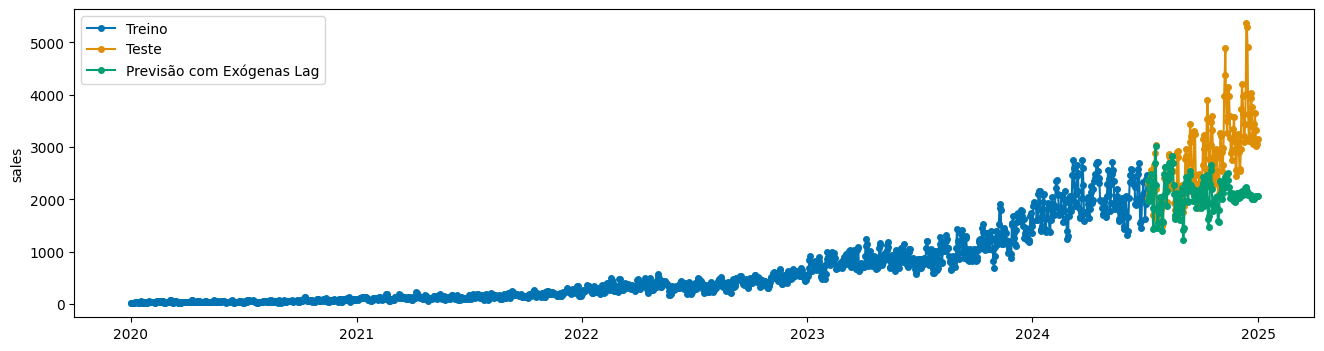

In [16]:
y_pred_case3 = model.predict(fh=y_test.index, X=X_test_missing)
plot_series(y_train, y_test, y_pred_case3, labels=["Treino", "Teste", "Previsão com Exógenas Lag"])